## Classification Project
## Loan approval analysis

### About this file
* Data set taken from : https://datahack.analyticsvidhya.com/contest/practice-problem-loan-prediction-iii/

### Problem Statement
#### About Company
* Dream Housing Finance company deals in all home loans. They have presence across all urban, semi urban and rural areas. Customer first apply for home loan after that company validates the customer eligibility for loan.

### Problem
* Company wants to automate the loan eligibility process (real time) based on customer detail provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. To automate this process, they have given a problem to identify the customers segments, those are eligible for loan amount so that they can specifically target these customers. Here they have provided a partial data set.

>__Loan_Approval_Analysis.csv__
  * Loan_Id : Unique Loan ID
  * Gender : Male/Female
  * Married : Applicant married (Y/N)
  * Dependents : Number of dependents
  * Education : Applicant Education (Graduate/Under Graduate)
  * Self_Employed : Self employed (Y/N)
  * ApplicantIncome : Applicant income
  * CoapplicantIncome : Coapplicant income
  * LoanAmount : Loan amount in thousands
  * Loan_Amount_Term : Term of loan in months
  * Credit_History : Credit history meets guidelines
  * Property_Area : Urban/Semi Urban/Rural
  * Loan_Status : Loan approved (Y/N)
      

# **Data Acquisition**


### Import Library

In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
sns.set_style('whitegrid')

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score

# Algorithm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Tools for classification analysis
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc

# Tuning model
from sklearn.model_selection import GridSearchCV

# Save model
import joblib

### Collecting Data

In [93]:
missing_sign = ['n/a', 'na', 'nan', '--,' 'none', 'NaN']
df_loan = pd.read_csv('loan_train.csv', na_values=missing_sign)

In [94]:
df_loan.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [95]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [96]:
df_loan.describe(include='all')

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
count,614,601,611,599,614,582,614.000000,614.000000,592.000000,600.00000,564.000000,614,614
unique,614,2,2,4,2,2,NaN,NaN,NaN,NaN,NaN,3,2
top,LP001002,Male,Yes,0,Graduate,No,NaN,NaN,NaN,NaN,NaN,Semiurban,Y
freq,1,489,398,345,480,500,NaN,NaN,NaN,NaN,NaN,233,422
mean,NaN,NaN,NaN,NaN,NaN,NaN,5403.459283,1621.245798,146.412162,342.00000,0.842199,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,6109.041673,2926.248369,85.587325,65.12041,0.364878,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,150.000000,0.000000,9.000000,12.00000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,2877.500000,0.000000,100.000000,360.00000,1.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,3812.500000,1188.500000,128.000000,360.00000,1.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,5795.000000,2297.250000,168.000000,360.00000,1.000000,NaN,NaN


# **Data Preparation**


In [97]:
df_prep = df_loan.copy()

In [98]:
# Delete column unused
df_prep.drop('Loan_ID', axis=1, inplace=True)

In [99]:
# Determine data type
def convert_data_type(data):
    cat_cols = [column for column in data.columns if data[column].nunique() <= 10]
    data[cat_cols] = data[cat_cols].astype('category')
    num_cols = [column for column in data.columns if data[column].dtypes in ['int64', 'float64']]
    return cat_cols, num_cols

In [100]:
cat_cols, num_cols = convert_data_type(df_prep)
print("Numerical type : {}\nCategorical type : {}".format(num_cols, cat_cols))

Numerical type : ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
Categorical type : ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status']


In [101]:
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Gender             601 non-null    category
 1   Married            611 non-null    category
 2   Dependents         599 non-null    category
 3   Education          614 non-null    category
 4   Self_Employed      582 non-null    category
 5   ApplicantIncome    614 non-null    int64   
 6   CoapplicantIncome  614 non-null    float64 
 7   LoanAmount         592 non-null    float64 
 8   Loan_Amount_Term   600 non-null    category
 9   Credit_History     564 non-null    category
 10  Property_Area      614 non-null    category
 11  Loan_Status        614 non-null    category
dtypes: category(9), float64(2), int64(1)
memory usage: 21.3 KB


## Exploratory data analysis

### Univariate Analysis

In [102]:
# Categorical type
def plot_qty_values(data, cat_cols, nrows=3, ncols=3):
  count = 0
  fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25,15))
  for row in range(nrows):
    for col in range(ncols):
      df_count = data[cat_cols[count]].value_counts(normalize=True).to_frame(name='Count')
      sns.barplot(x=df_count.index,
                  y=df_count['Count'],
                  order=df_count.index,
                  ax=ax[row,col])
      for x, y in enumerate(df_count.iterrows()):
        ax[row,col].text(x, y[1]['Count']+0.005, '{:.2f}'.format(y[1]['Count']), ha='center', color='gray')
        ax[row,col].set(ylabel=None)
        ax[row,col].set(title=cat_cols[count])
        ax[row,col].set(xlabel=None)
        ax[row,0].set(ylabel='Percentage of value')
      count += 1

In [103]:
# Numerical type
def plot_histograms(data, num_cols):
  ncols = len(num_cols)
  fig, (ax_box, ax_hist) = plt.subplots(nrows=2, ncols=ncols, gridspec_kw={'height_ratios':(.15, .85)}, figsize=(25,5))
  for idx, column in enumerate(num_cols):
    sns.boxplot(data=data, x=column, ax=ax_box[idx])
    sns.histplot(data=data, x=column, kde=True, ax=ax_hist[idx])
    if idx != 0:
      ax_hist[idx].set(ylabel='')
    ax_box[idx].set(xlabel='')

In [104]:
def plot_value(data):
    cat_cols, num_cols = convert_data_type(data)
    plot_qty_values(data, cat_cols)
    plot_histograms(data, num_cols)

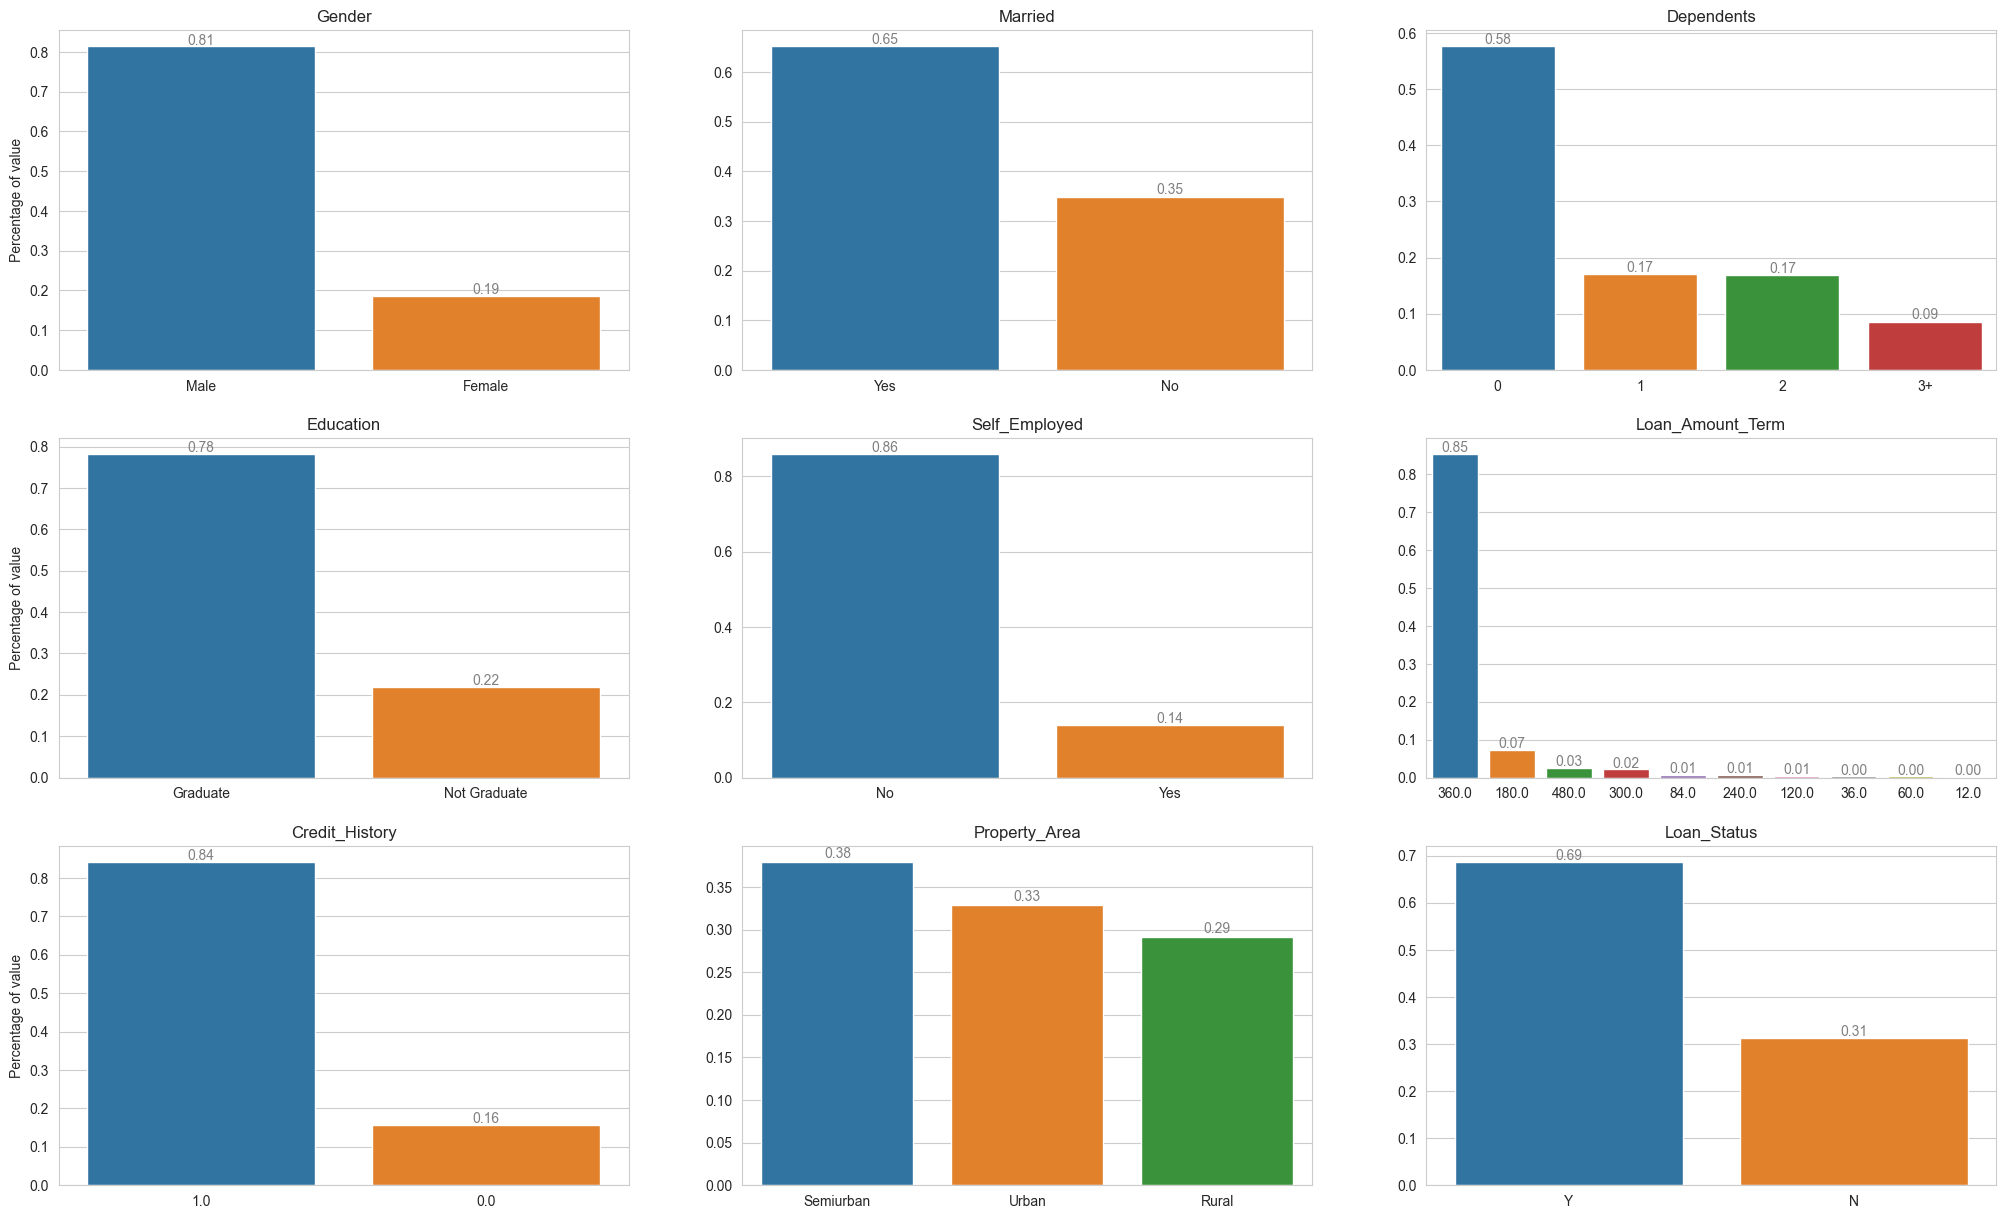

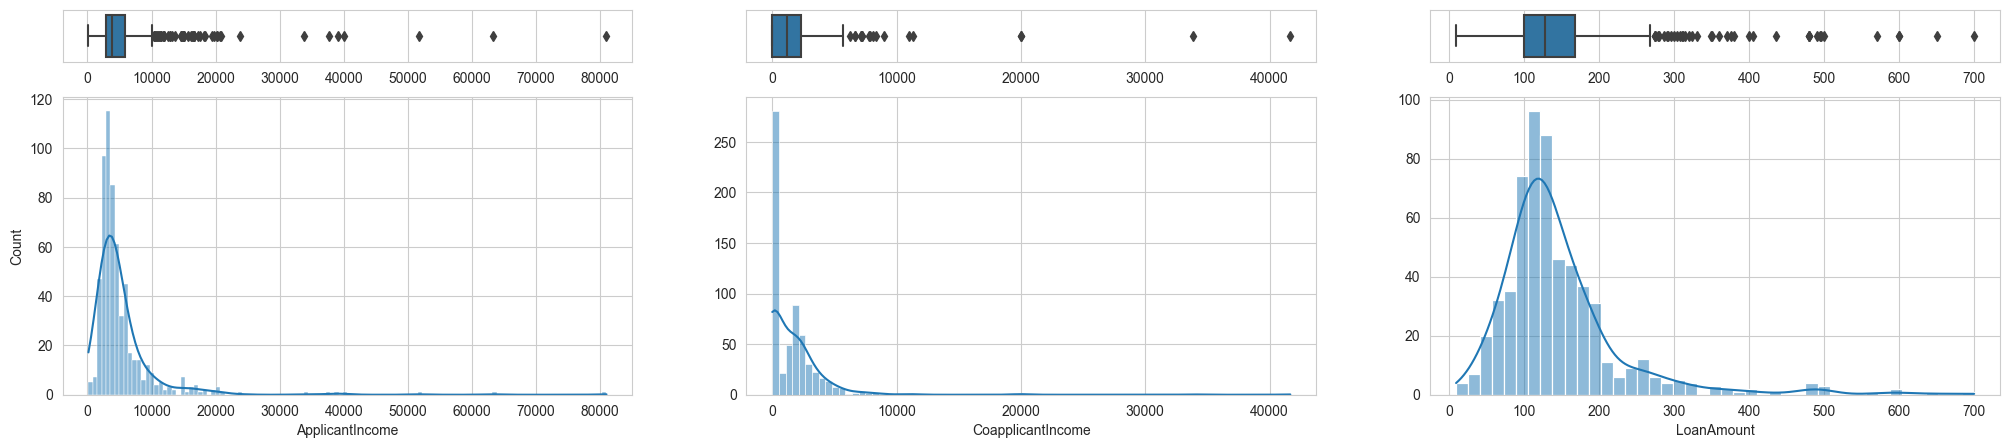

In [105]:
plot_value(df_prep)

### Bivariate Analysis

In [106]:
def bivariate_plot(data, target, nrows=4, ncols=2):
  count = 0
  cat_cols, num_cols = convert_data_type(data)
  feature = cat_cols
  feature.remove(target)
  fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,15))
  for row in range(nrows):
    for col in range(ncols):
      df_cross = pd.crosstab(data[feature[count]], data[target])
      df_cross.div(df_cross.sum(1), axis=0).plot(kind='bar',
                                                 stacked=True,
                                                 ax=ax[row,col])
      ax[row,col].tick_params(axis='x', rotation=0)
      ax[row,0].set(ylabel='Percentage of value')
      count += 1

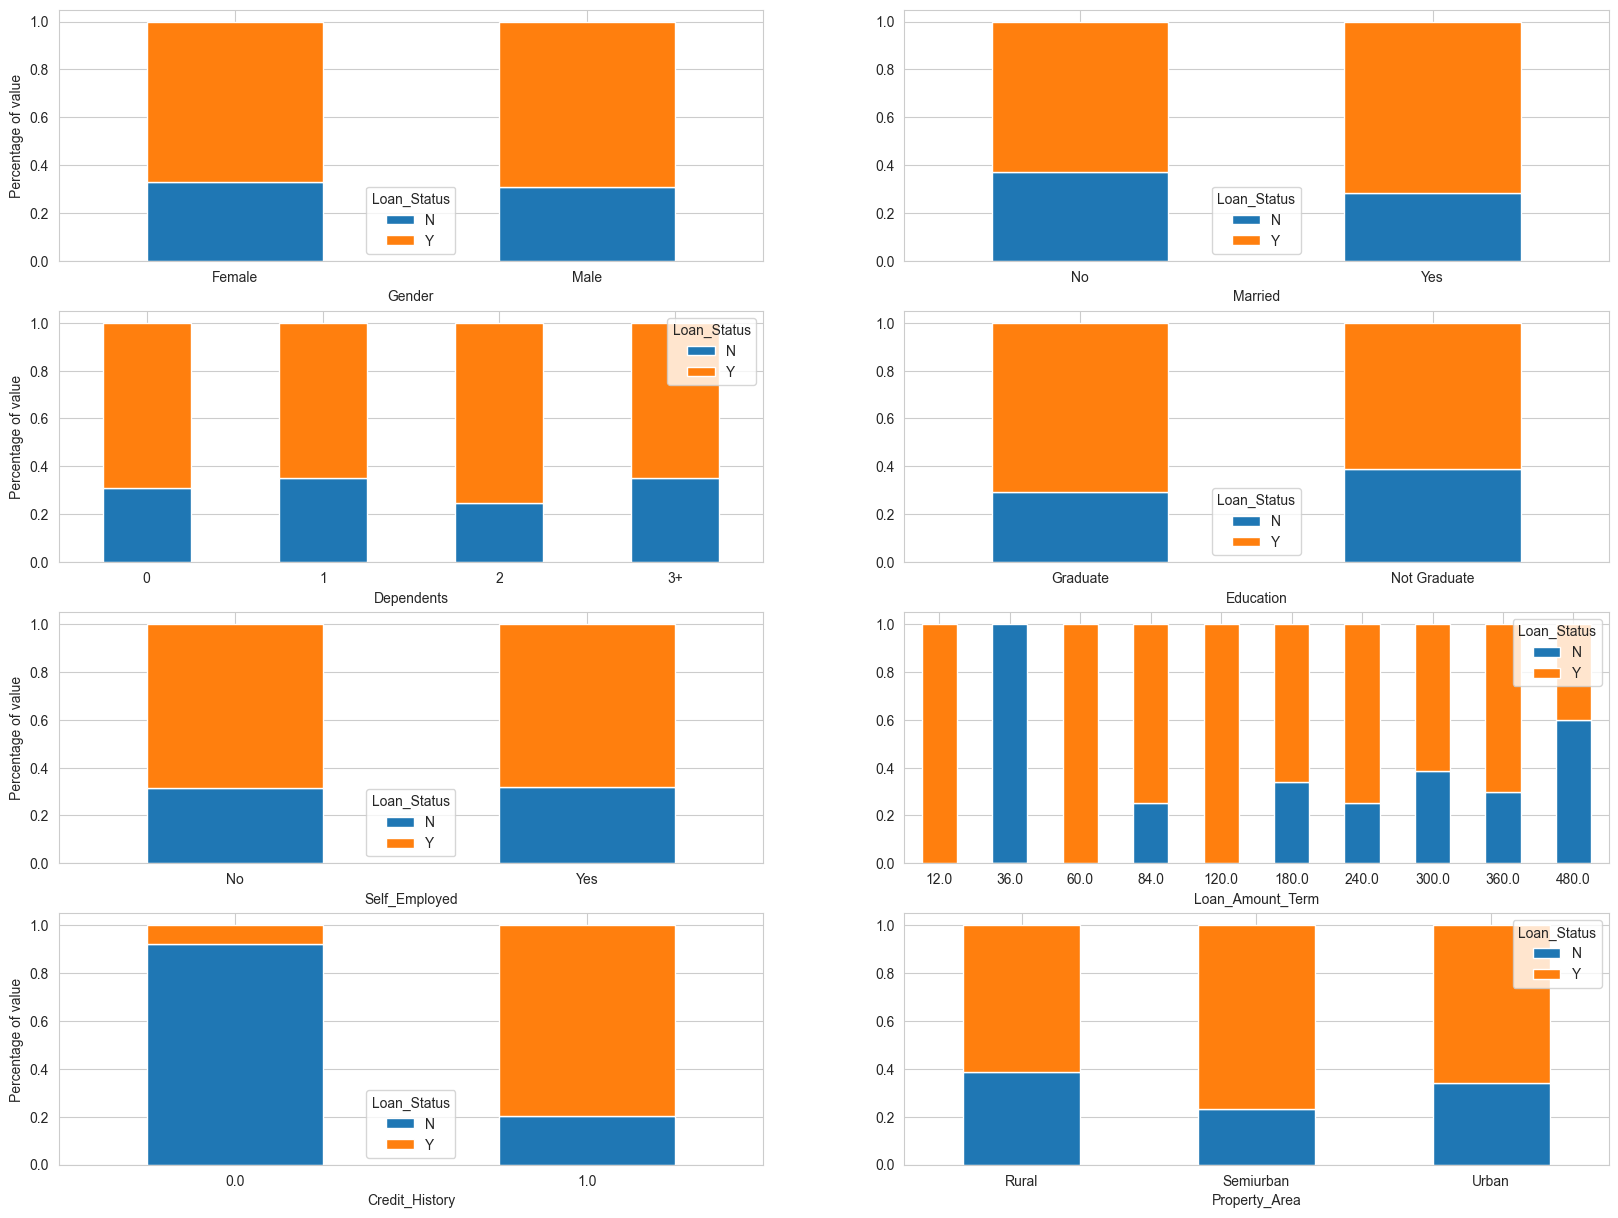

In [107]:
target = 'Loan_Status'
bivariate_plot(df_prep, target)

## Data Cleaning

In [108]:
df_cleanMiss = df_prep.copy()

### Missing value

In [109]:
def check_miss_values(data):
  missing_count = data.isnull().sum()
  percent_missing = missing_count*100/data.isnull().count()
  total_cell = np.prod(data.shape)
  total_missing = missing_count.sum()*100/total_cell
  print("Percenct Missing Value Each Columns\n{}".format(percent_missing.round(2)))
  print("Total missing values : {:.2f}%".format(total_missing))

In [110]:
# Handle missing value
def impute_mode_value(data, column):
  mode_value = data[column].mode()[0]
  data[column].fillna(mode_value, inplace=True)

def impute_median_value(data, column):
  median_value = data[column].median()
  data[column].fillna(median_value, inplace=True)

def impute_miss_value(data):
  for column in data.columns:
    if column in cat_cols:
      impute_mode_value(data, column)
    else:
      impute_median_value(data, column)

In [111]:
check_miss_values(df_cleanMiss)

Percenct Missing Value Each Columns
Gender               2.12
Married              0.49
Dependents           2.44
Education            0.00
Self_Employed        5.21
ApplicantIncome      0.00
CoapplicantIncome    0.00
LoanAmount           3.58
Loan_Amount_Term     2.28
Credit_History       8.14
Property_Area        0.00
Loan_Status          0.00
dtype: float64
Total missing values : 2.02%


In [112]:
impute_miss_value(df_cleanMiss)

In [113]:
check_miss_values(df_cleanMiss)

Percenct Missing Value Each Columns
Gender               0.0
Married              0.0
Dependents           0.0
Education            0.0
Self_Employed        0.0
ApplicantIncome      0.0
CoapplicantIncome    0.0
LoanAmount           0.0
Loan_Amount_Term     0.0
Credit_History       0.0
Property_Area        0.0
Loan_Status          0.0
dtype: float64
Total missing values : 0.00%


### Outlier

In [114]:
df_cleanOut = df_cleanMiss.copy()

In [115]:
# Identifying Outliers with IQR (Interquartile range)
def clean_outlier_iqr(data):
    count = 1
    cat_cols, num_cols = convert_data_type(data)
    while count != 0:
        count = 0
        for column in num_cols:
            q1 = data[column].quantile(0.25)
            q3 = data[column].quantile(0.75)
            iqr = q3-q1
            upper_whisker = q3+(1.5*iqr)
            lower_whisker = q1-(1.5*iqr)
            idx_out = data.loc[(data[column]>upper_whisker) | (data[column]<lower_whisker)].index
            data.drop(idx_out, inplace=True)
            count += len(idx_out)
    qty_outlier = df_cleanMiss.shape[0]-data.shape[0]
    percent_outlier = (qty_outlier*100)/df_cleanMiss.shape[0]
    print("Outlier : {} units ({:.2f}%) has been deleted".format(qty_outlier, percent_outlier))
    data.reset_index(drop=True, inplace=True)

In [116]:
clean_outlier_iqr(df_cleanOut)

Outlier : 160 units (26.06%) has been deleted


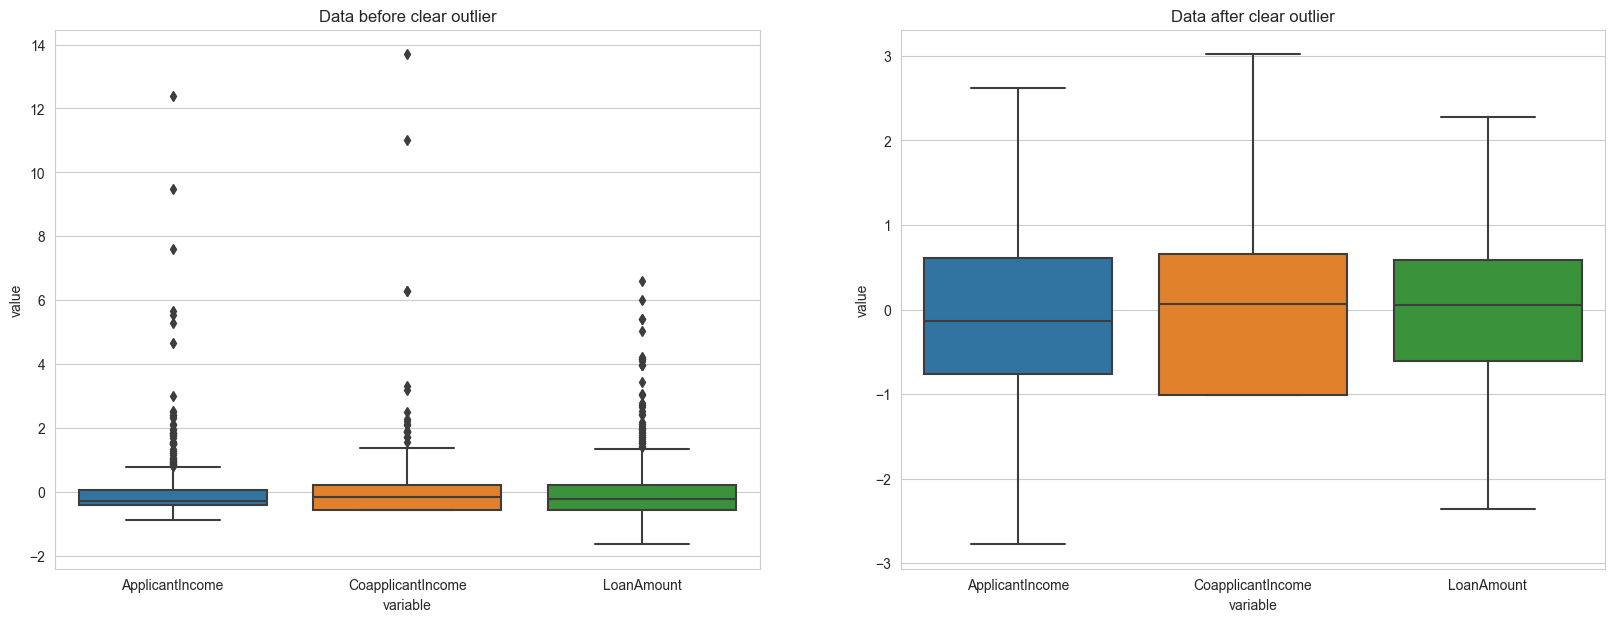

In [117]:
# Plot distribution of data (numerical variable)
fig, ax = plt.subplots(ncols=2, figsize=(20,7))
cat_cols, num_cols = convert_data_type(df_cleanMiss)
sns.boxplot(data=pd.melt(zscore(df_cleanMiss[num_cols])),
            x='variable',
            y='value',
            ax=ax[0]
            ).set_title('Data before clear outlier')
sns.boxplot(data=pd.melt(zscore(df_cleanOut[num_cols])),
            x='variable',
            y='value',
            ax=ax[1]
            ).set_title('Data after clear outlier');

## Data transformation

In [155]:
df_trans = df_cleanOut.copy()

In [156]:
df_trans.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,128.0,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [120]:
class Data():
    def __init__(self, data):
        self.data = data
    
    def transform_data(self):
        cat_cols,num_cols = convert_data_type(self.data)
        for column in self.data.columns:
            if column in cat_cols:
                self.__encode_label(column)
            else:
                self.__scale_feature(column)

    def __encode_label(self, column):
        encode = LabelEncoder()
        self.data[column] = encode.fit_transform(self.data[column])

    def __scale_feature(self, column):
        sc = StandardScaler()
        self.data[column] = sc.fit_transform(np.array(self.data[column]).reshape(-1,1))

In [157]:
trans = Data(df_trans)
trans.transform_data()

In [158]:
df_trans.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1,0,0,0,0,1.835521,-1.006059,0.290787,6,1,2,1
1,1,1,1,0,0,0.811155,0.138996,0.290787,6,1,0,0
2,1,1,0,0,1,-0.469707,-1.006059,-1.580088,6,1,2,1
3,1,1,0,1,0,-0.807116,0.784418,0.049384,6,1,2,1
4,1,0,0,0,0,1.957700,-1.006059,0.683067,6,1,2,1


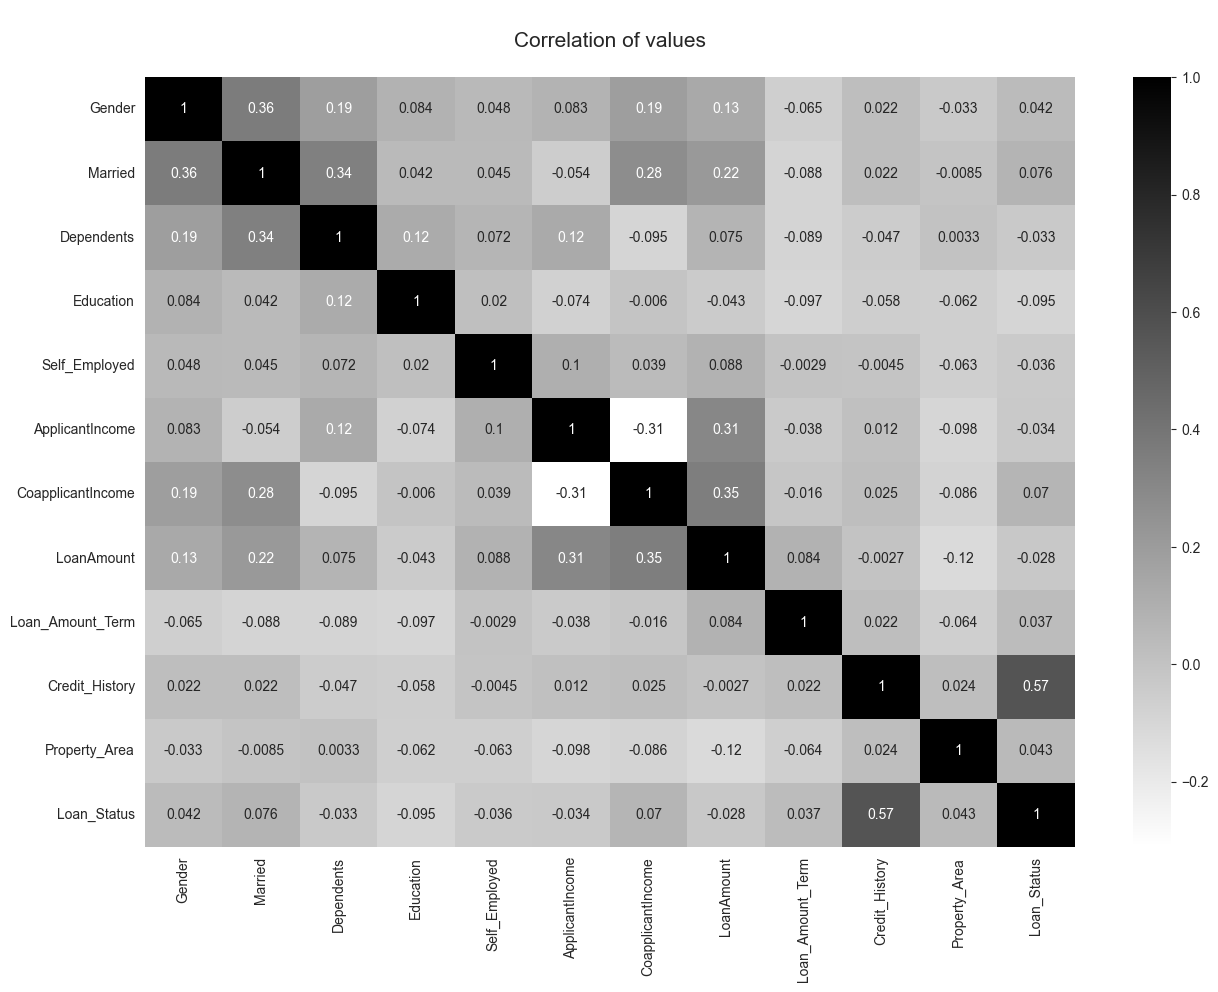

In [123]:
# Check correlation of values
corr = df_trans.corr()
plt.figure(figsize=(15, 10))
ax = sns.heatmap(corr, annot=True, cmap='binary')
ax.set_title('\nCorrelation of values\n', fontsize=15);

# **Modeling**

In [124]:
class Splitting_Data(Data):
    def __init__(self, data, target):
        super().__init__(data)
        self.x = self.data.drop(target, axis=1)
        self.y = self.data[target]
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.x, self.y, test_size=0.2, random_state=25)

## Compare model

In [125]:
class Comparing(Splitting_Data):
	def compare_model(self, algorithms):
		r_score = dict()
		for name,model in algorithms.items():
			cvs = cross_val_score(model, self.x, self.y, cv=10)
			r_score[name] = cvs.mean()*100
		return pd.Series(r_score, name='Score(%)')

In [159]:
target = 'Loan_Status'
algorithms = {
    'LogisticRegression' : LogisticRegression(),
    'NaiveBayes' : GaussianNB(),
    'SupportVectorMachine' : SVC(),
    'DecisionTree' : DecisionTreeClassifier(),
    'RandomForest' : RandomForestClassifier()
}

In [160]:
cf = Comparing(df_trans, target)
score = cf.compare_model(algorithms)
print("{}\n\nAlgorithm '{}' has the highest efficiency ({:.2f}%)".format(score, score.idxmax(), score.max()))

LogisticRegression      81.951691
NaiveBayes              81.507246
SupportVectorMachine    81.951691
DecisionTree            69.826087
RandomForest            80.845411
Name: Score(%), dtype: float64

Algorithm 'LogisticRegression' has the highest efficiency (81.95%)


In [161]:
model = algorithms.get(score.idxmax())
model

LogisticRegression()

## Train model

In [278]:
class Training(Splitting_Data):
  def __init__(self, data, target, model):
    super().__init__(data, target)
    self.model = model
    self.model.fit(self.x_train, self.y_train)

  def save_model(self):
    file_name = "regression_model.pkl"
    joblib.dump(self.model, file_name)
  
  def report_model(self):
    self.__plot_roc_curve()
    y_predict = self.model.predict(self.x_test)
    report = classification_report(self.y_test, y_predict, target_names=['No','Yes'])
    accuracy = accuracy_score(self.y_test, y_predict)
    cm = confusion_matrix(self.y_test, y_predict)
    print(f'Use algorithm : {self.model}')
    print('-'*60)
    print(f'Classification Report :\n{report}')
    print('-'*60)
    print(f'Accuracy : {accuracy*100:.4f}%')
    print('-'*60)
    print(f'Confusion Matrix :\n{cm}')
    print('-'*60)

  def __plot_roc_curve(self):
    target_value = 1
    y_predict_proba = self.model.predict_proba(self.x_test)
    fpr, tpr, thresholds = roc_curve(self.y_test, y_predict_proba[:,target_value])
    auc_value = auc(fpr, tpr)
    lower_left = [0,1]
    upper_right = [0,1]
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr)
    plt.plot(lower_left, upper_right, '--r')
    plt.title('ROC curve [AUC : {:.4f}]'.format(auc_value))
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)');

Use algorithm : LogisticRegression()
------------------------------------------------------------
Classification Report :
              precision    recall  f1-score   support

          No       1.00      0.54      0.70        28
         Yes       0.83      1.00      0.91        63

    accuracy                           0.86        91
   macro avg       0.91      0.77      0.80        91
weighted avg       0.88      0.86      0.84        91

------------------------------------------------------------
Accuracy : 85.7143%
------------------------------------------------------------
Confusion Matrix :
[[15 13]
 [ 0 63]]
------------------------------------------------------------


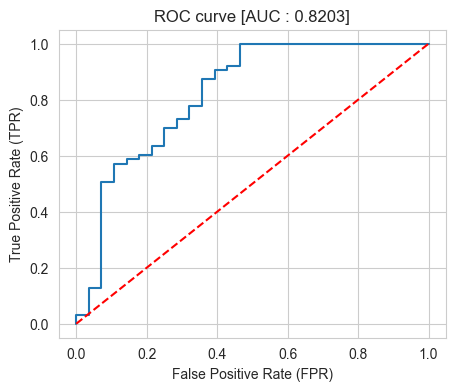

In [179]:
train = Training(df_trans, target, model)
train.report_model()

In [180]:
train.save_model()

LogisticRegression()

## Tune model

In [298]:
class Tuning(Training):
  def __init__(self, data, target, model, param_dist):
    super().__init__(data, target, model)
    self.new_model = self.__find_parameter(param_dist)
    self.my_threshold = self.__adjust_threshold(self.new_model)

  def __find_parameter(self, param_dist):
    all_process = -1
    lr_search = GridSearchCV(estimator=self.model, param_grid=param_dist, n_jobs=all_process)
    lr_search.fit(self.x_train, self.y_train)
    new_model = lr_search.best_estimator_
    return new_model

  def __adjust_threshold(self, model, max_loop=1_000):
    r_score = dict()
    for round in range(max_loop):
      threshold = (round+1)/max_loop
      y_predict = self.predict_value(model, threshold, self.x_test)
      acc_score = accuracy_score(self.y_test, y_predict)
      r_score[threshold] = acc_score
    score = pd.Series(r_score, name='Score(%)')
    my_threshold = score.idxmax()
    return my_threshold

  def save_model(self):
    file_name = "regression_model.pkl"
    joblib.dump(self.new_model, file_name)
    return self.new_model

  def report_model(self):
    y_predict = self.predict_value(self.new_model, self.my_threshold, self.x_test)
    report = classification_report(self.y_test, y_predict, target_names=['No','Yes'])
    accuracy = accuracy_score(self.y_test, y_predict)
    cm = confusion_matrix(self.y_test, y_predict)
    print(f'Use algorithm : {self.new_model}')
    print('-'*60)
    print(f'Threshold : {self.my_threshold}')
    print('-'*60)
    print(f'Classification Report :\n{report}')
    print('-'*60)
    print(f'Accuracy : {accuracy*100:.4f}%')
    print('-'*60)
    print(f'Confusion Matrix :\n{cm}')
    print('-'*60)

  def predict_value(self, model, threshold, feature):
    y_predict_proba = model.predict_proba(feature)[:,1]
    y_predict = y_predict_proba > threshold
    return y_predict

In [299]:
param_dist = {
    'C' : [0.001,0.01, 0.1, 1, 10, 100],
    'fit_intercept' : [True, False],
    'penalty' : ['l1', 'l2'],
    'max_iter' : list(range(100, 800, 100)),
    'solver' : ['liblinear'],
}

In [300]:
tune = Tuning(df_trans, target, model, param_dist)
tune.report_model()

Use algorithm : LogisticRegression(C=0.1, penalty='l1', solver='liblinear')
------------------------------------------------------------
Threshold : 0.729
------------------------------------------------------------
Classification Report :
              precision    recall  f1-score   support

          No       1.00      0.57      0.73        28
         Yes       0.84      1.00      0.91        63

    accuracy                           0.87        91
   macro avg       0.92      0.79      0.82        91
weighted avg       0.89      0.87      0.86        91

------------------------------------------------------------
Accuracy : 86.8132%
------------------------------------------------------------
Confusion Matrix :
[[16 12]
 [ 0 63]]
------------------------------------------------------------


In [301]:
tune.save_model()

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

# **Feature Engineering**

In [302]:
new_df = df_cleanOut.copy()
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454 entries, 0 to 453
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Gender             454 non-null    category
 1   Married            454 non-null    category
 2   Dependents         454 non-null    category
 3   Education          454 non-null    category
 4   Self_Employed      454 non-null    category
 5   ApplicantIncome    454 non-null    int64   
 6   CoapplicantIncome  454 non-null    float64 
 7   LoanAmount         454 non-null    float64 
 8   Loan_Amount_Term   454 non-null    category
 9   Credit_History     454 non-null    category
 10  Property_Area      454 non-null    category
 11  Loan_Status        454 non-null    category
dtypes: category(9), float64(2), int64(1)
memory usage: 16.2 KB


In [303]:
def find_EMI(loan_amount, loan_amount_term, interest_per_year):
    month_in_year = 12
    interest_per_month = interest_per_year/month_in_year
    return (loan_amount*interest_per_month*(1+interest_per_month)**loan_amount_term)/(((1+interest_per_month)**loan_amount_term)-1)

In [304]:
def add_new_feature(data):
    # Convert data type
    data['Loan_Amount_Term'] = data['Loan_Amount_Term'].astype('float64')
    # Create new feature
    data['Term_more_15years'] = np.where(data['Loan_Amount_Term'] >= 84, True, False)

    # Lets assume that interest rate = 3.5% per year
    # interest
    data['interest'] = np.where(data['Term_more_15years'] == True, 0.035, 0.05)
    # Add a 2% interest increase for those with no credit history
    data.loc[data['Credit_History'] == 0, 'interest'] += 0.02
    # Add a 0.25% interest increase for those with self employed
    data.loc[data['Self_Employed'] == 'Yes', 'interest'] += 0.0025

    data['LoanAmount'] = data['LoanAmount']*1_000
    data['EMI'] = find_EMI(loan_amount=data['LoanAmount'], loan_amount_term=data['Loan_Amount_Term'], interest_per_year=data['interest'])
    
    data['totalIncome'] = data['ApplicantIncome'] + data['CoapplicantIncome']
    data['totalIncome_per_EMI'] = data['EMI']/data['totalIncome']

    data['totalIncome_per_EMI_less_than_35%'] = np.where(data['totalIncome_per_EMI'] < 0.35, True, False)
    
    cols_drop = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'EMI', 'totalIncome_per_EMI']
    data.drop(cols_drop, axis=1, inplace=True)

In [305]:
add_new_feature(new_df)

In [306]:
new_df.head()

,Gender,Married,Dependents,Education,Self_Employed,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Term_more_15years,interest,totalIncome,totalIncome_per_EMI_less_than_35%
0,Male,No,0,Graduate,No,360.0,1.0,Urban,Y,True,0.0350,5849.0,True
1,Male,Yes,1,Graduate,No,360.0,1.0,Rural,N,True,0.0350,6091.0,True
2,Male,Yes,0,Graduate,Yes,360.0,1.0,Urban,Y,True,0.0375,3000.0,True
3,Male,Yes,0,Not Graduate,No,360.0,1.0,Urban,Y,True,0.0350,4941.0,True
4,Male,No,0,Graduate,No,360.0,1.0,Urban,Y,True,0.0350,6000.0,True


### Creating new features

In [248]:
# Convert data type
new_df['Loan_Amount_Term'] = new_df['Loan_Amount_Term'].astype('float64')

In [249]:
new_df['Term_more_3years'] = np.where(new_df['Loan_Amount_Term'] >= 84, True, False)

In [250]:
# Lets assume that interest rate = 3.5% per year
new_df['interest'] = np.where(new_df['Term_more_3years'] == True, 0.035, 0.05)
new_df.loc[new_df['Credit_History'] == 0, 'interest'] += 0.02
new_df.loc[new_df['Self_Employed'] == 'Yes', 'interest'] += 0.0025

In [251]:
def find_EMI(loan_amount, loan_amount_term, interest_per_year):
    month_in_year = 12
    interest_per_month = interest_per_year/month_in_year
    return (loan_amount*interest_per_month*(1+interest_per_month)**loan_amount_term)/(((1+interest_per_month)**loan_amount_term)-1)

In [252]:
new_df['LoanAmount'] = new_df['LoanAmount']*1_000
new_df['EMI'] = find_EMI(loan_amount=new_df['LoanAmount'], loan_amount_term=new_df['Loan_Amount_Term'], interest_per_year=new_df['interest'])

In [253]:
new_df['totalIncome'] = new_df['ApplicantIncome'] + new_df['CoapplicantIncome']
new_df['totalIncome_per_EMI'] = new_df['EMI']/new_df['totalIncome']

In [254]:
new_df['totalIncome_per_EMI_less_than_35%'] = np.where(new_df['totalIncome_per_EMI'] < 0.35, True, False)

In [255]:
cols_drop = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'EMI', 'totalIncome_per_EMI']
new_df.drop(cols_drop, axis=1, inplace=True)

## Data Transformation

In [307]:
trans = Data(new_df)
trans.transform_data()

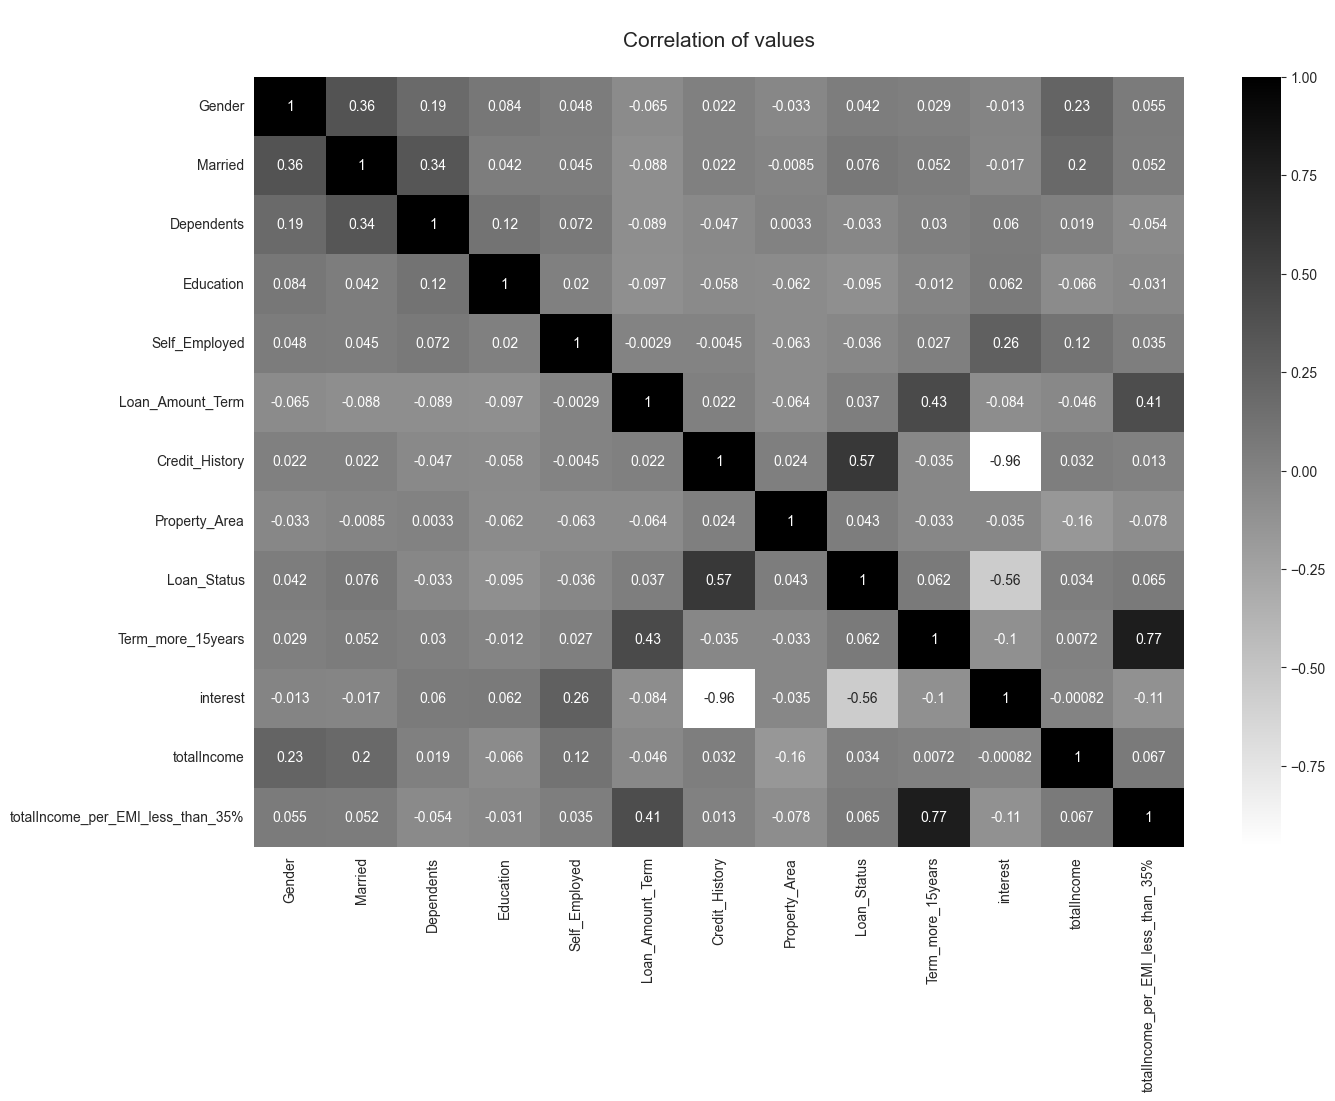

In [308]:
# Check correlation of values
corr = new_df.corr()
plt.figure(figsize=(15, 10))
ax = sns.heatmap(corr, annot=True, cmap='binary')
ax.set_title('\nCorrelation of values\n', fontsize=15);

## Compare model

In [309]:
cf = Comparing(new_df, target)
score = cf.compare_model(algorithms)
print("{}\n\nThe algorithm '{}' has the highest efficiency ({:.2f}%)".format(score, score.idxmax(), score.max()))

LogisticRegression      82.173913
NaiveBayes              81.729469
SupportVectorMachine    81.951691
DecisionTree            74.251208
RandomForest            79.318841
Name: Score(%), dtype: float64

The algorithm 'LogisticRegression' has the highest efficiency (82.17%)


In [310]:
# Choose model has the most efficiency
model = algorithms.get(score.idxmax())
model

LogisticRegression()

## Train model

Use algorithm : LogisticRegression()
------------------------------------------------------------
Classification Report :
              precision    recall  f1-score   support

          No       1.00      0.54      0.70        28
         Yes       0.83      1.00      0.91        63

    accuracy                           0.86        91
   macro avg       0.91      0.77      0.80        91
weighted avg       0.88      0.86      0.84        91

------------------------------------------------------------
Accuracy : 85.7143%
------------------------------------------------------------
Confusion Matrix :
[[15 13]
 [ 0 63]]
------------------------------------------------------------


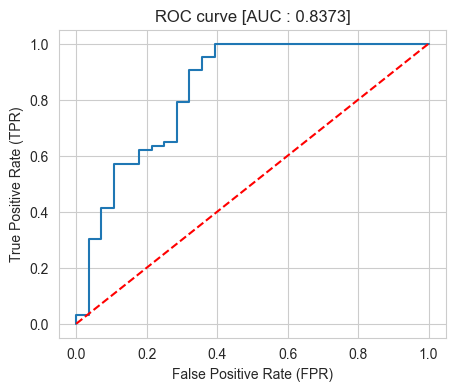

In [311]:
train = Training(new_df, target, model)
train.report_model()

## Tune model

In [276]:
param_dist = {
    'C' : [0.001,0.01, 0.1, 1, 10, 100],
    'fit_intercept' : [True, False],
    'penalty' : ['l1', 'l2'],
    'max_iter' : list(range(100, 800, 100)),
    'solver' : ['liblinear'],
}

In [312]:
tune = Tuning(new_df, target, model, param_dist)
tune.report_model()

Use algorithm : LogisticRegression(C=0.1, penalty='l1', solver='liblinear')
------------------------------------------------------------
Threshold : 0.561
------------------------------------------------------------
Classification Report :
              precision    recall  f1-score   support

          No       1.00      0.57      0.73        28
         Yes       0.84      1.00      0.91        63

    accuracy                           0.87        91
   macro avg       0.92      0.79      0.82        91
weighted avg       0.89      0.87      0.86        91

------------------------------------------------------------
Accuracy : 86.8132%
------------------------------------------------------------
Confusion Matrix :
[[16 12]
 [ 0 63]]
------------------------------------------------------------


In [313]:
tune.save_model()

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')